# Noise-induced schooling of fish
In this project we want to simulate the dynamics of schools of fish and compare the results with those shown in [\[1\]](https://doi.org/10.1038/s41567-020-0787-y). In particular, we focus on a mean field model based on pairwise interactions. 

## Pairwise copying model
Denoting with $\mathbf{\hat{d}}_i(t)$ the direction of the $i$-th fish at time $t$ ($i=1, ..., N$)

$$
\mathbf{\hat{d}}_i(t) = \begin{pmatrix} \cos\theta_i(t) \\ \sin\theta_i(t)\end{pmatrix}
$$

the angle $\theta_i(t)$ follows a stochastic protocol characterized by 2 underlying behaviour.

**1. Spontaneous change of direction** <br>
Every fish can spontaneously change its direction at a constant rate per unit time $s$:
$$
    \theta_i \xrightarrow{s} \theta_i + \mathcal{N}_{trunc}(0, \epsilon, -\pi, \pi)
$$ 
where $\mathcal{N}_{trunc}(0, \epsilon, -\pi, \pi)$ is a truncated normal distribution with zero mean, variance $\epsilon$, normalized over the integral $(-\pi, \pi)$.

**2. Pairwise interaction** <br>
At a different rate $c$, a given fish $i$ selects at random another fish $j$ from the whole school and copies it:
$$
    \theta_i +\theta_{i\neq j} \xrightarrow{c} 2\theta_j
$$ 
In this case we are not considering _local_ interactions, instead we are assuming the system is "mean field" or "fully connected".

In [1]:
library(truncnorm)
library(gridExtra)
library(latex2exp)
library(glue)
library(ggplot2)

library(rayshader)
library(rgl)

# Simulation
Regarding the values of the general and model parameters, we use those reported in [\[1\]](https://doi.org/10.1038/s41567-020-0787-y). In particular we set $s=0.25$ and $c=4$. Then, we define the following variables:
- `Nfish`: vector with the number of fishes, $N = \{15, 30, 60\}$
- `dt`: time interval, $\delta t = 0.12$
- `TIME`: total duration of the simulation, $3.5$ hours
- `e`: variance of the truncated normal distribution, $\epsilon=\pi/3$





In [2]:
# update function
update <- function(thetas_t, Nfish_) {
    thetas_new <- vector(length=Nfish_)
    choice <- runif(Nfish_)

    # copy
    mask_c <- choice <= c_step

    for (i in which(mask_c)){
        thetas_new[i] <- thetas_t[sample(setdiff(1:Nfish_, i), 1)]
    }

    # random change
    mask_r <- choice <= (s_step+c_step) & choice > c_step
    thetas_new[mask_r] <- thetas_t[mask_r] + rtruncnorm(sum(mask_r), a=-pi, b=pi, mean=0, sd=sqrt(e))

    # do nothing
    mask_n <- choice > (s_step + c_step)
    thetas_new[mask_n] <- thetas_t[mask_n]

    return(thetas_new)
}

In [3]:
# running the simulation
simulation <- function(Nfish_){
    # initializing directions uniformly
    thetas <- matrix(data=c(runif(Nfish_, -pi, pi), rep(NA, Nfish_*(steps))), nrow=Nfish_, ncol=steps+1)

    # update directions at each step
    for (t in 1:steps) {
        thetas[, t+1] <- update(thetas[, t], Nfish_)
    }

    return(thetas)
}

In [4]:
# general parameters
Nfish <- c(15, 30, 60)
dt    <- 0.12
TIME  <- 1.5*3600
steps <- TIME / dt

# times
times <- seq(from=0, to=TIME, length=steps+1)

# model parameters
s <- 0.25
c <- 4                # it means 4 times per second
e <- pi/3

s_step <- s*dt
c_step <- c*dt

# run the simulation for diffent N values
thetas_N <- list()

for (i in seq_along(Nfish)){
    thetas_N[[i]] <- simulation(Nfish[i])
}

# Group polarization
The group polarization 
$$
    \mathbf{M}(t_n)=\frac{1}{N}\sum_{i=1}^{N}\mathbf{\hat{v}}_i (t_n) = 
    \frac{1}{N}\sum_{i=1}^{N} \begin{pmatrix} \cos\theta_i(t_n) \\ \sin\theta_i(t_n)\end{pmatrix}
$$

measures the degree of alignment of the group at time $t_n$. We compute it at each time step using the results of the simulation and we plot the time series of $|\mathbf{M}|$ and the corresponding probability density distribution.

In [5]:
fun_polarization <- function(theta_t, Nfish_){

    return(
        c(sum(cos(theta_t))/Nfish_, sum(sin(theta_t))/Nfish_)
    )
}

In [6]:
# initialize lists 
polarization_t <- list()
pol_magnitude <- list()

for (i in seq_along(Nfish)){
    polarization_t[[i]] <- apply(thetas_N[[i]], 2, function(x) {fun_polarization(x, Nfish[i])})
    pol_magnitude[[i]]  <- apply(polarization_t[[i]], 2, function(x){sqrt(sum(x^2))})
}


## Time series

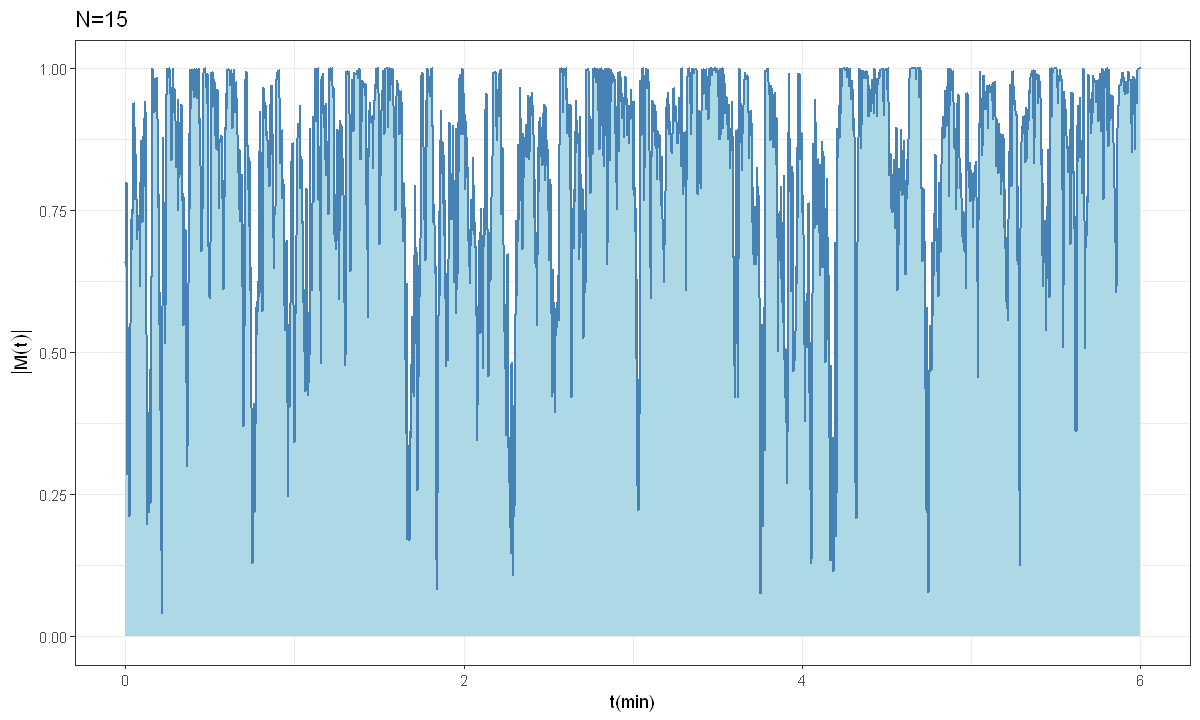

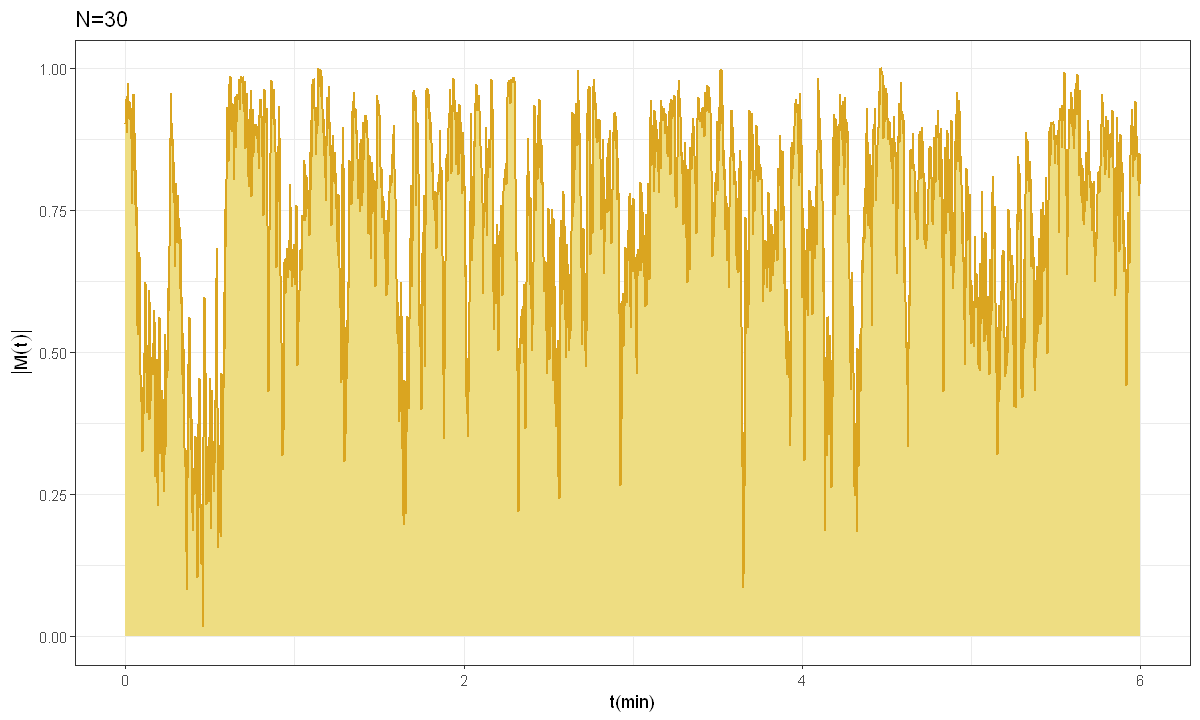

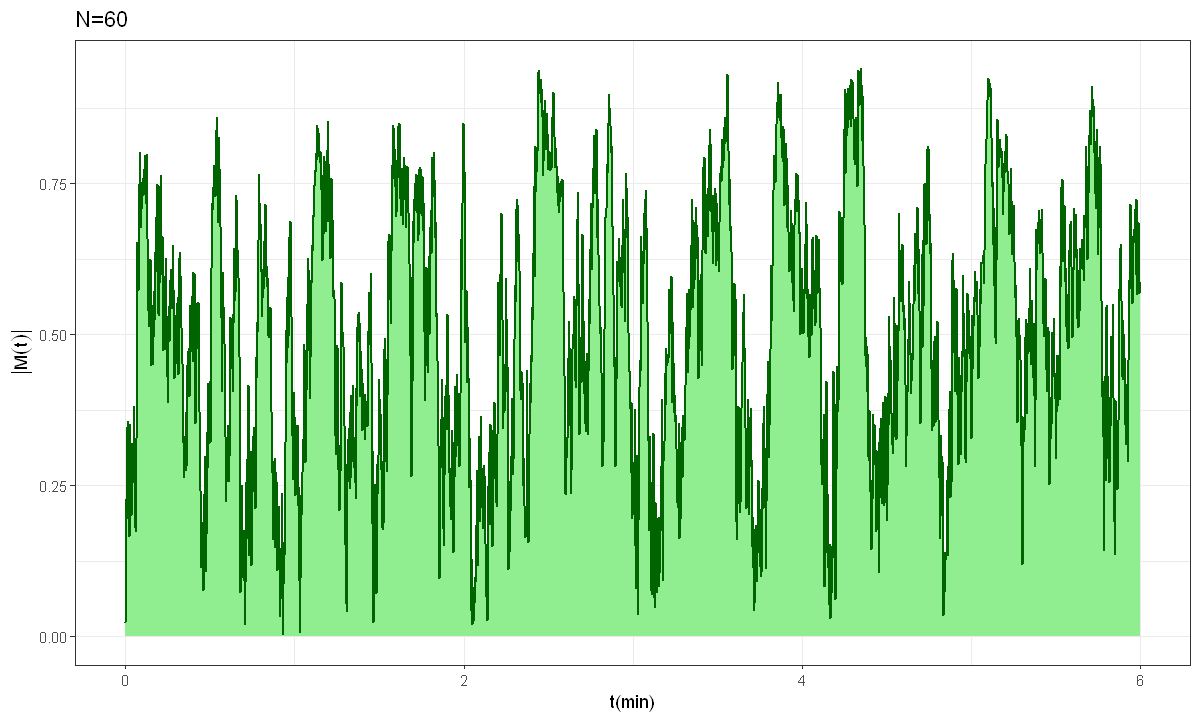

In [7]:
minutes  <- 6
thinning <- 1
mask_last <- seq(steps+1-minutes*60/dt, steps+1, by=thinning)
times_    <- (times[mask_last] - times[mask_last[1]])/60

colors_fill  = c('lightblue', 'lightgoldenrod', 'lightgreen')
colors_color = c('steelblue', 'goldenrod', 'darkgreen')

options(repr.plot.width=10, repr.plot.height=6)

gg_timeseries <- function(Nfish_, pol_mag_, color_, fill_){
    ggplot()+
    geom_area(aes(x=times_, y=pol_mag_), color=color_, fill=fill_, size=0.7)+
    labs(
        title=paste('N=', Nfish_, sep=''), 
        x='t(min)', 
        y=TeX('$|M(t)|$')
    )+
    theme_bw()
}

for (i in seq_along(Nfish)){
    plot(gg_timeseries(Nfish[i], pol_magnitude[[i]][mask_last], colors_color[i], colors_fill[i]))
    ggsave(paste('images/magM_timeseries_', Nfish[i], '.pdf', sep=''), device='pdf', width=8, height=5, units='in')
}


## Probability density

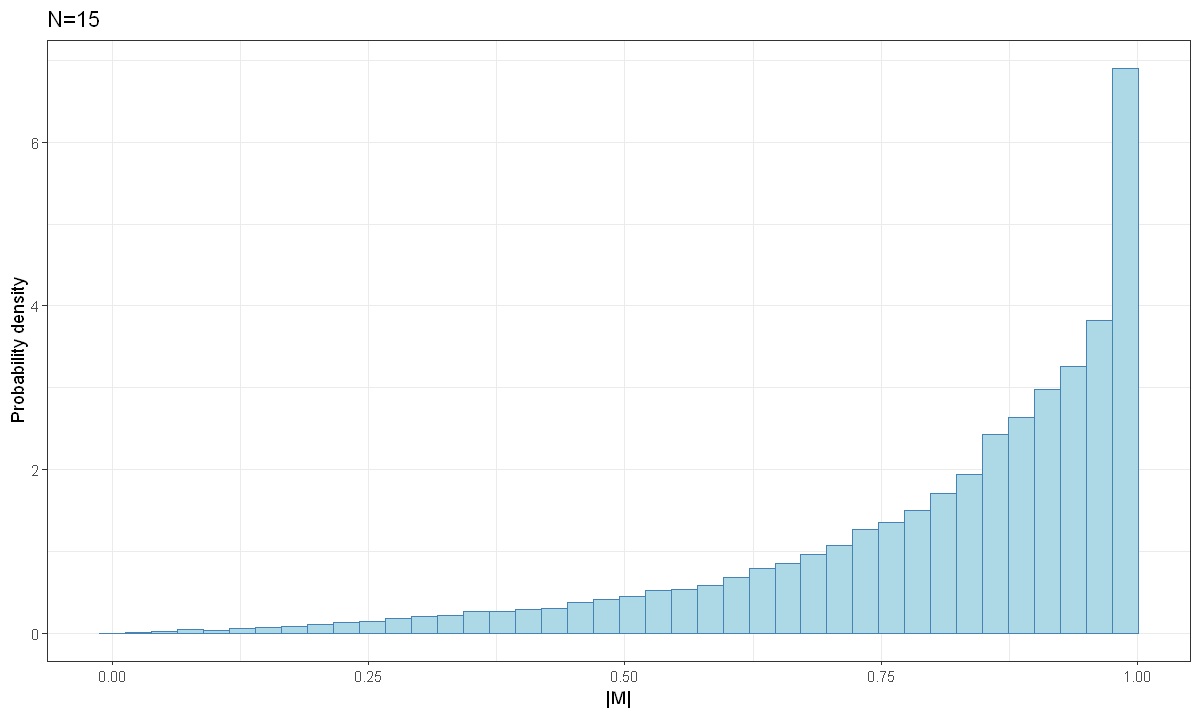

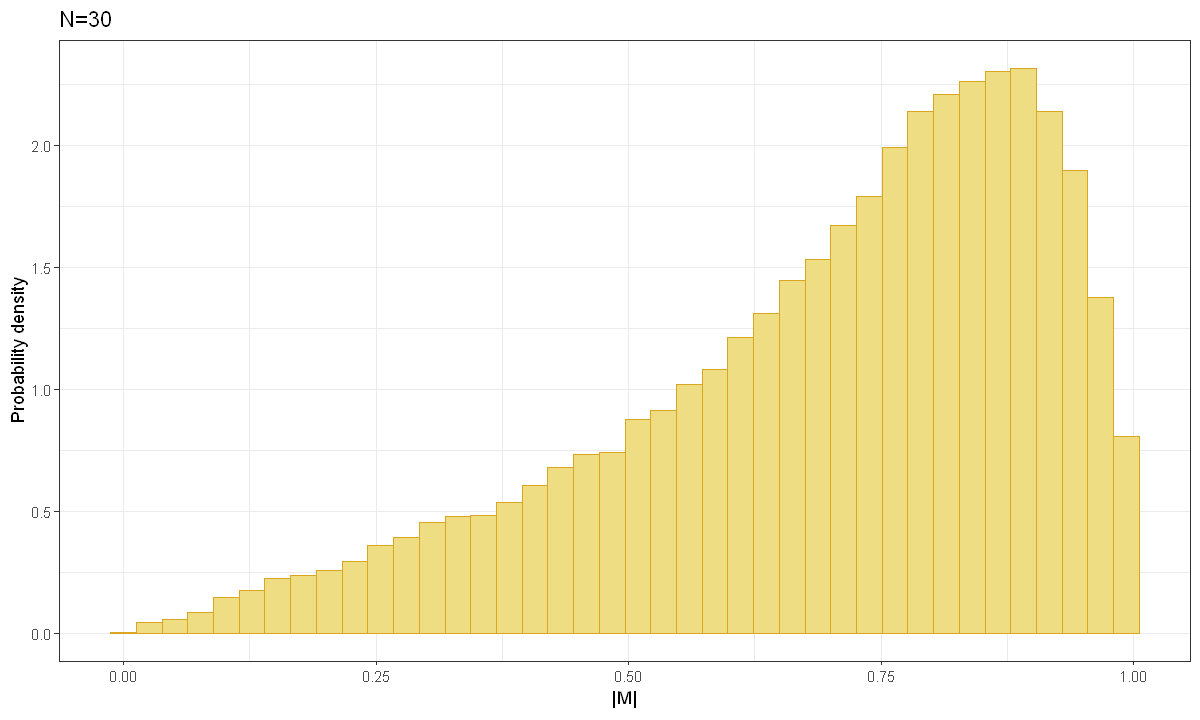

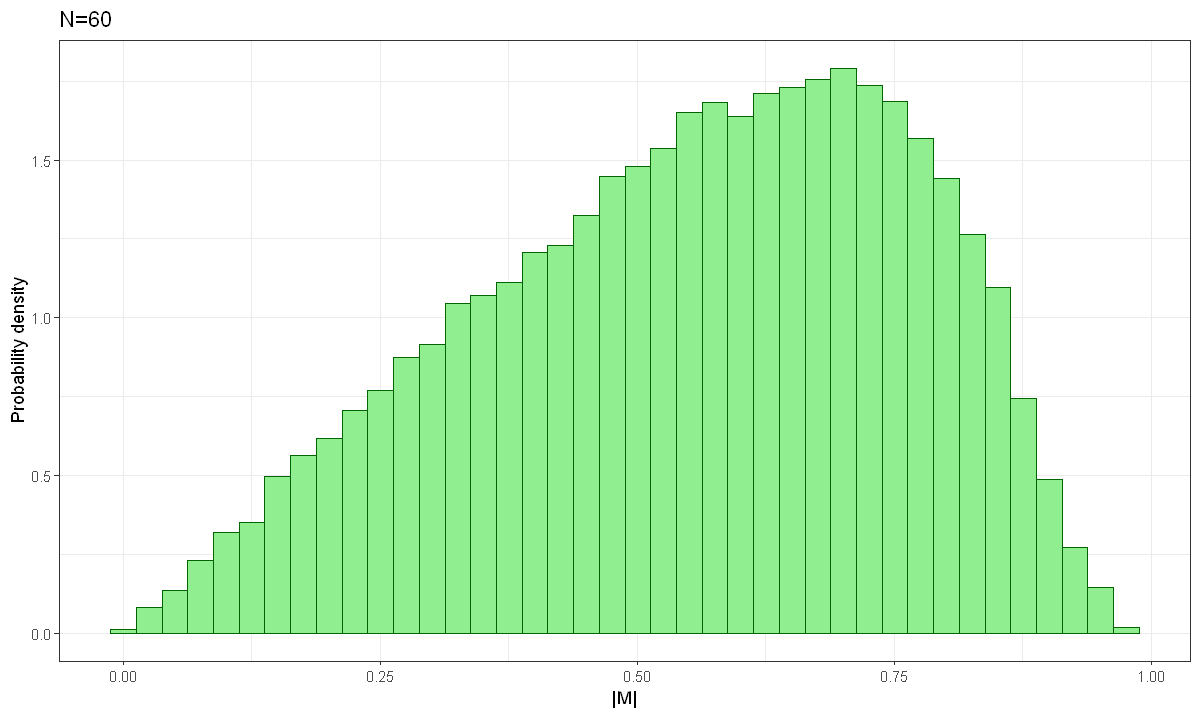

In [8]:
plt_list <- list()

gg_pdf <- function(N, pol_magn_, color_, fill_){
    plt <- ggplot()+
            geom_histogram(aes(x=pol_magn_, y=..density..), bins=40, color=color_, fill=fill_)+
            labs(
                title=paste('N=', N, sep=''),
                x=TeX('|M|'),
                y='Probability density'
            )+
            theme_bw()
    return(plt)
}


for (i in seq_along(Nfish)){
    plot(gg_pdf(Nfish[i], pol_magnitude[[i]], colors_color[i], colors_fill[i]))
    ggsave(paste('images/magM_hist_', Nfish[i], '.pdf', sep=''), device='pdf', width=8, height=5, units='in')
}


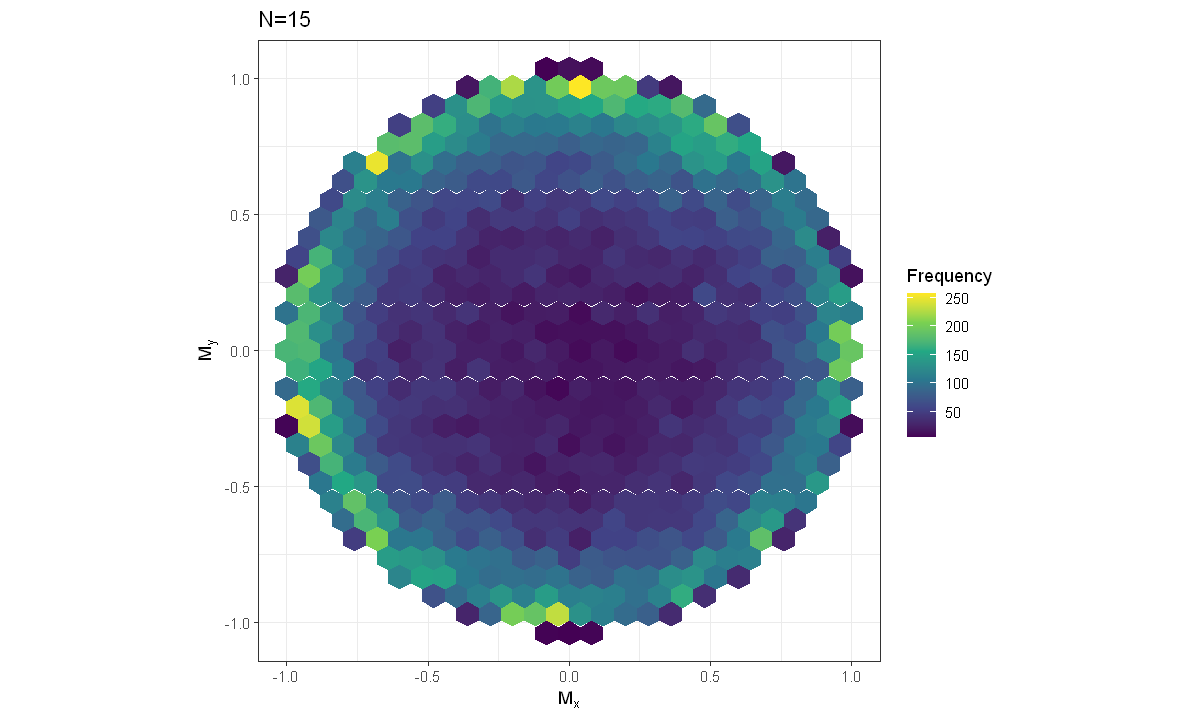

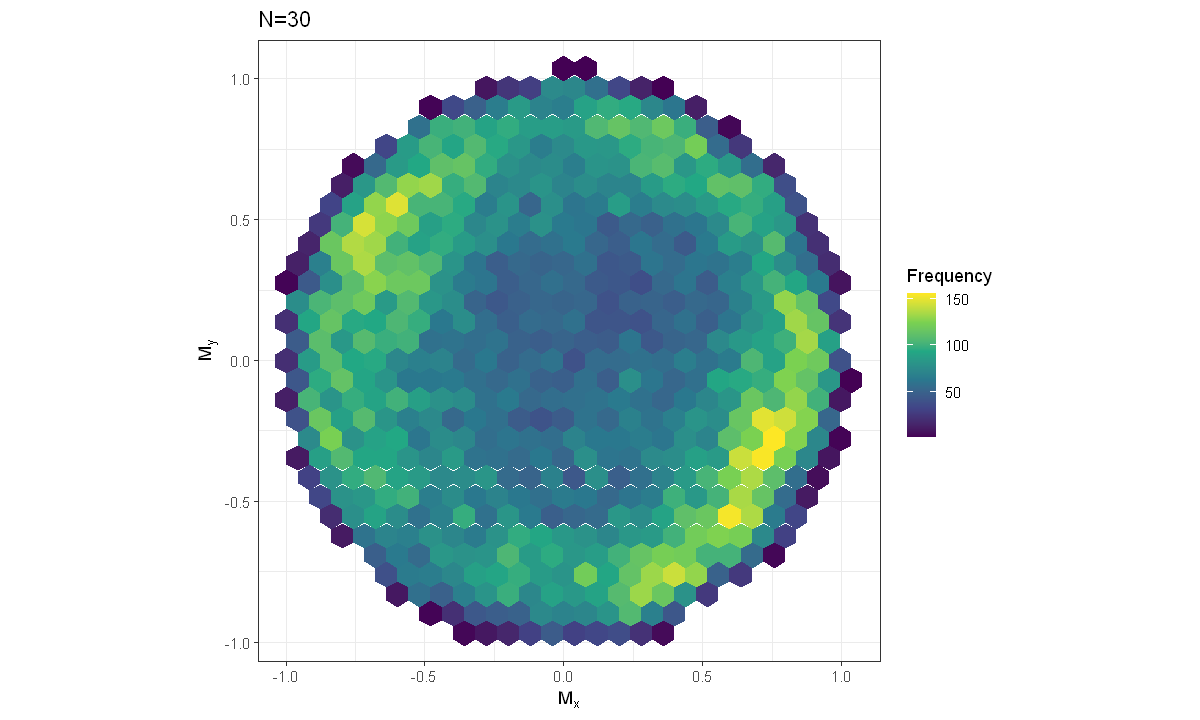

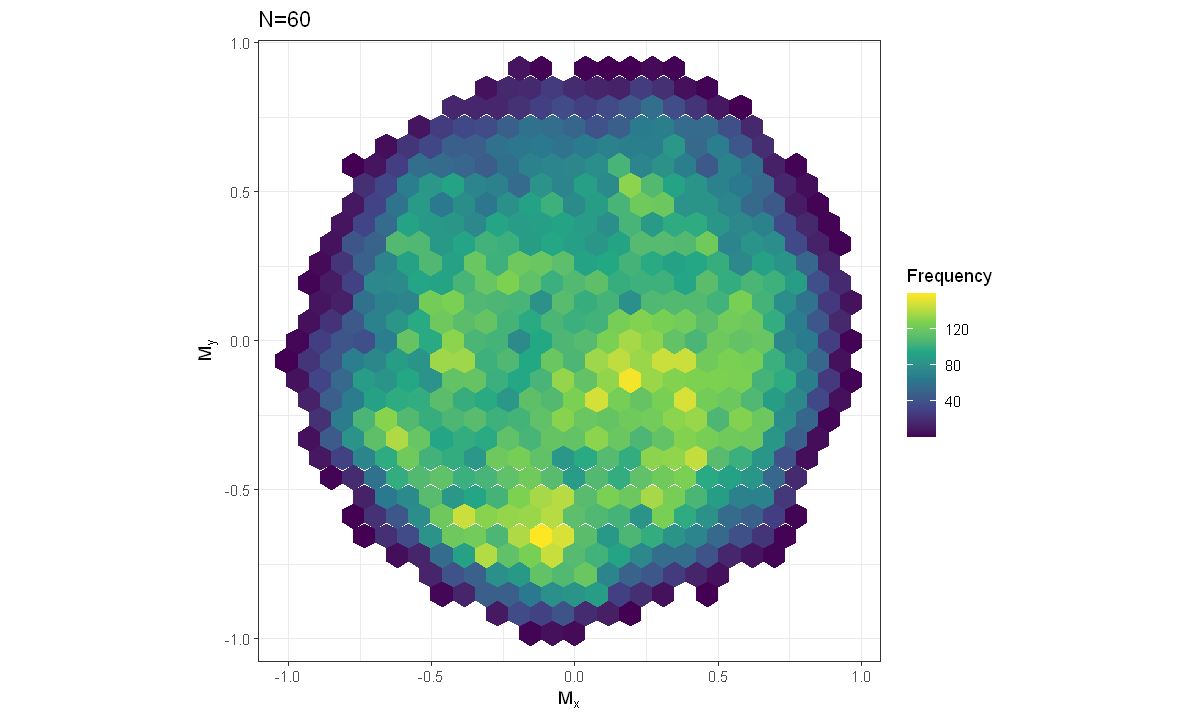

In [9]:
gg_3d <- function(Nfish_, polariz_t_){
    ggplot()+
        geom_hex(aes(x=polariz_t_[1,], y=polariz_t_[2,]), bins=25)+
        scale_fill_continuous(type = "viridis") +
        labs(
            title=paste('N=', Nfish_, sep=''), 
            x=TeX('$M_x$'), 
            y=TeX('$M_y$'), 
            fill='Frequency'
        )+
        theme_bw()+
        theme(aspect.ratio=1)
} 

for (i in seq_along(Nfish)){
    plot(gg_3d(Nfish[i], polarization_t[[i]]))
    ggsave(paste('images/MxMy_hist_', Nfish[i], '.pdf', sep=''), device='pdf', width=8, height=5, units='in')
}

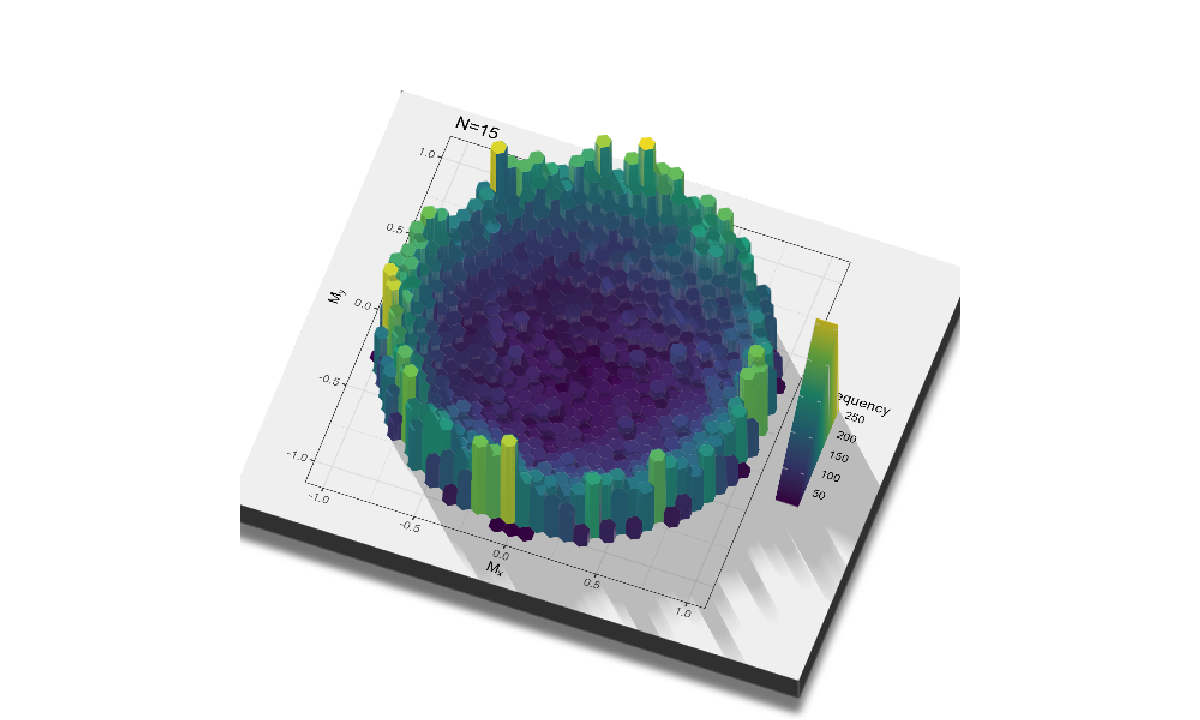

In [10]:
gg_tmp <- gg_3d(15, polarization_t[[1]])

plot_gg(gg_tmp, multicore=TRUE,height=5,width=6,scale=500)
render_camera(fov = 0, theta = 20, zoom = 0.75, phi = 60)
render_snapshot()

rgl.snapshot('images/3dplot_15.png', fmt = 'png')
rgl.close()

# rgl.postscript('3dplot_15.pdf', fmt = 'pdf')
# rgl.close()

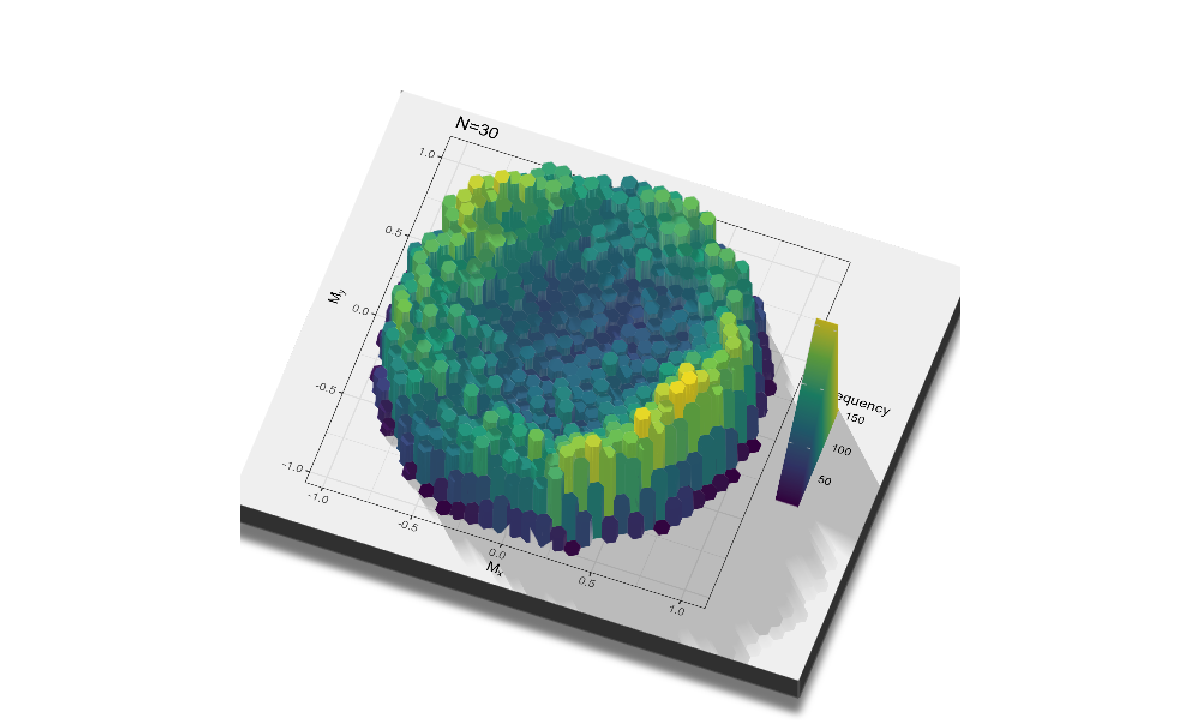

In [11]:
gg_tmp <- gg_3d(30, polarization_t[[2]])

plot_gg(gg_tmp, multicore=TRUE,height=5,width=6,scale=500)
render_camera(fov = 0, theta = 20, zoom = 0.75, phi = 60)
render_snapshot()

rgl.snapshot('images/3dplot_30.png', fmt = 'png')
rgl.close()

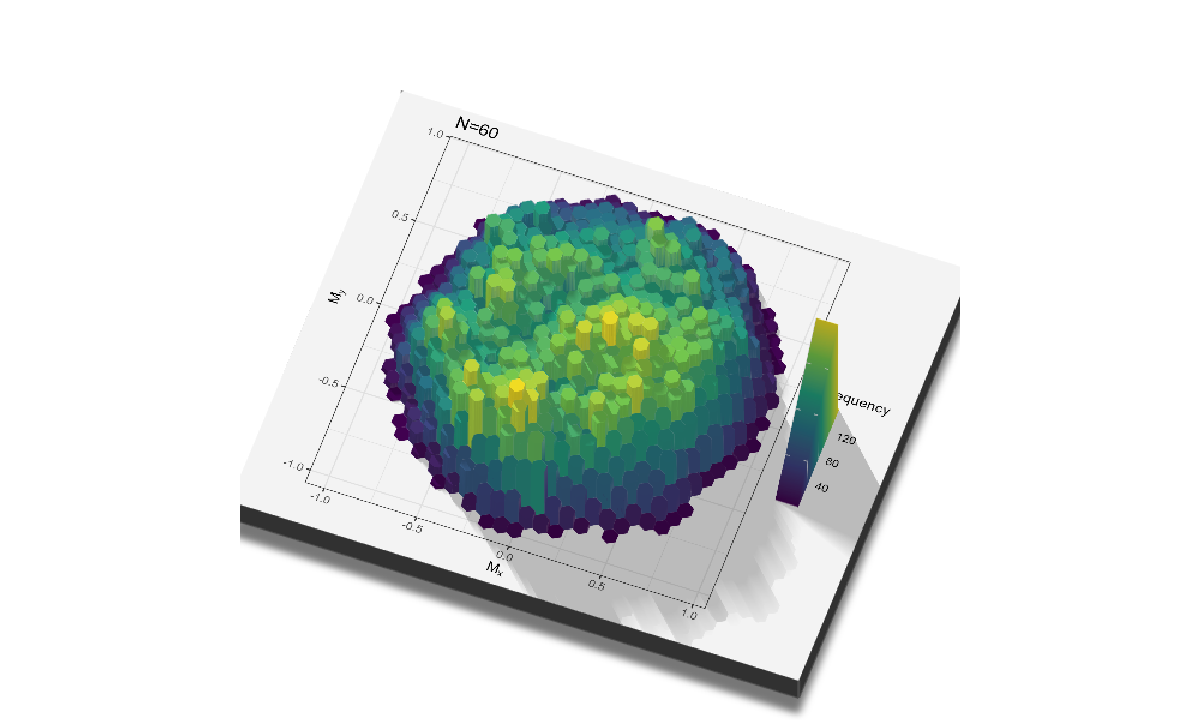

In [12]:
gg_tmp <- gg_3d(60, polarization_t[[3]])

plot_gg(gg_tmp, multicore=TRUE,height=5,width=6,scale=500)
render_camera(fov = 0, theta = 20, zoom = 0.75, phi = 60)
render_snapshot()

rgl.snapshot('images/3dplot_60.png', fmt = 'png')
rgl.close()

# References
[1] Jhawar, J., Morris, R.G., Amith-Kumar, U.R. et al. Noise-induced schooling of fish. Nat. Phys. 16, 488–493 (2020). https://doi.org/10.1038/s41567-020-0787-y

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d38e0de1-97c1-417e-9e66-77f45fe1f460' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>